___

# Machine Learning in Geosciences ] 
Department of Applied Geoinformatics and Carthography, Charles University

Lukas Brodsky lukas.brodsky@natur.cuni.cz


## Deep Learning - Convolutional Neural Networks

Task: This notebook presents object classification using a CNN model programmed with the PyTorch library https://pytorch.org. The example involves simulated objects (triangle, square, circle) in a random position. 

Architecture: fully connected network (FCN) for classification

**Tasks**: 
    
 1. Develop a complete workflow with the CNN architecture for object shape classification, including model implementation and modeling parameter settings. 
    
 2. Change the noise level from 0.1 to 0.5 and 0.9 and evaluate the learning accuracy.

Translated with DeepL.com (free version)

#### CNN architekture

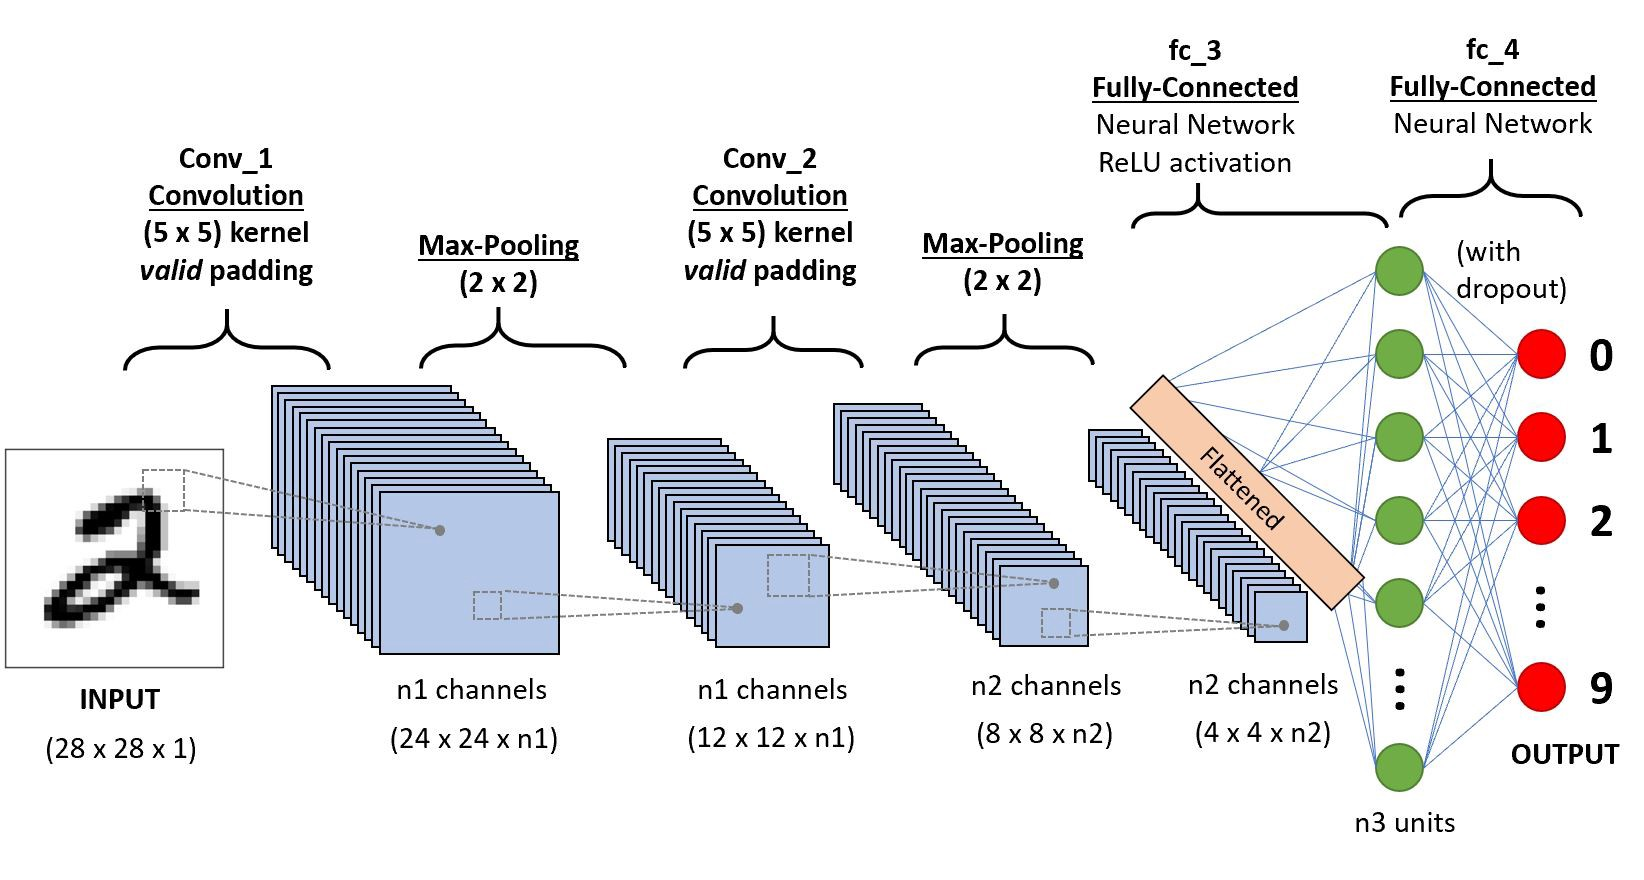

#### Main steps of the modelling workflow 
1. Loading the dataset
2. Create iterable dataset
3. Create model class
4. Instantiate model class
5. Instantiate loss class
6. Instantiate optimizer class
7. Model training

In [1]:
import numpy as np
np.random.seed(42) 
import matplotlib.pyplot as plt
import time 

# PyTorch imports 
import torch
import torch.nn as nn 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models
from torch.autograd import Variable

### Simulated data 

In [2]:
# Skript pro simulaci dat 
from simulate_images import generate_image_shapes

In [3]:
# Data generation
height, width, count = 28, 28, 9
noise = 0.2
X, Y, y_label = generate_image_shapes(height, width, count, noise)

In [4]:
X.shape

(9, 1, 28, 28)

In [5]:
Y.shape

(9, 1, 28, 28)

In [6]:
y_label

array([2, 0, 2, 2, 0, 0, 2, 1, 2])

In [7]:
np.unique(y_label)

array([0, 1, 2])

Label: 1


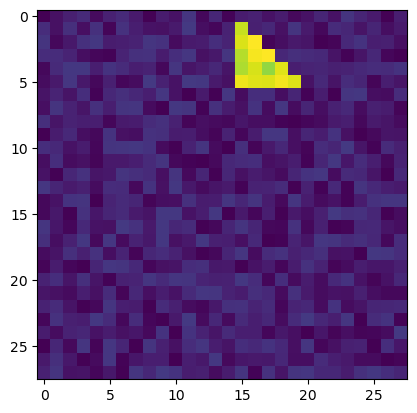

In [8]:
image_no=7
print(f'Label: {y_label[image_no]}')
plt.imshow(X[image_no][0,:,:])

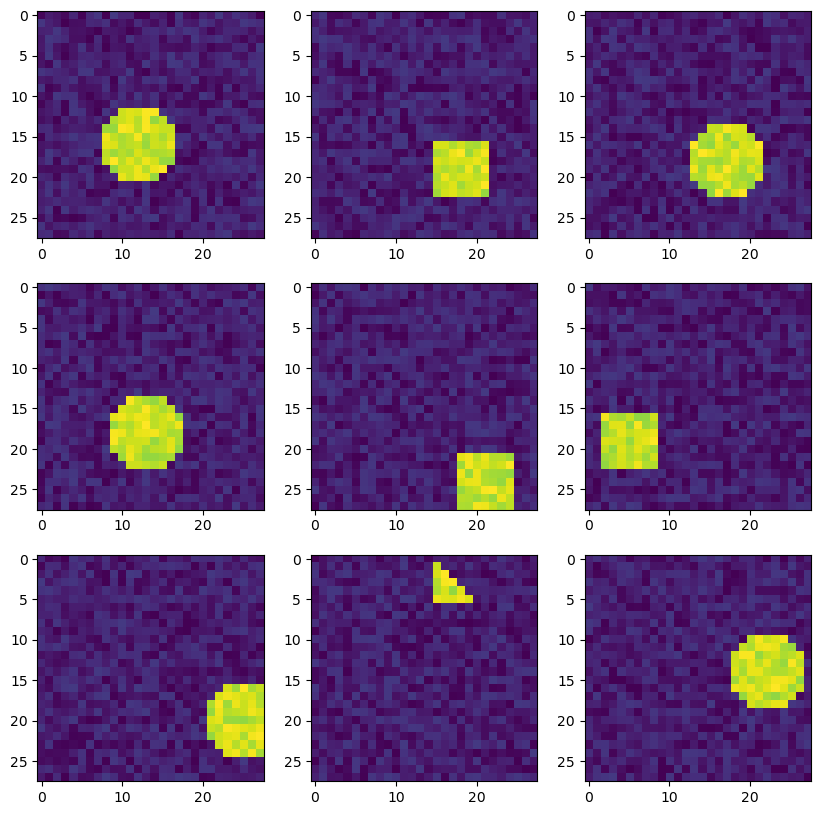

In [9]:
plt.figure(figsize=(10,10)) 

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X[i][0,:,:])


### 1. Class dataset for loading the data

In [10]:
class SimDataset(Dataset):
    def __init__(self, height, width, count, noise, transform=None):
        self.input_images, self.target_masks, self.target_labels= generate_image_shapes(height, width, count, noise)
        self.transform = transform

    def __len__(self):
        return len(self.input_images)

    def __getitem__(self, idx):
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        label= self.target_labels[idx] 
        if self.transform:
            image = self.transform(image)

        return [image, mask, label]


In [17]:
# test 
height, width, count = 28, 28, 9 
noise = 0.1
train_size = 1 
sd = SimDataset(height, width, train_size, noise) 

In [18]:
dl =  DataLoader(sd, batch_size=1, shuffle=True, num_workers=0)

In [19]:
for batch in dl:
    iamge, mask, label = batch
    print(label)

tensor([0])


### 2. Create iterable dataset

In [20]:
def get_data_loaders(height, width, noise, train_size, test_size, batch_size=5):
    
    trans = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.485], [0.229]) # imagenet
    ])

    # height, width, count = 64, 64
    train_set = SimDataset(height, width, train_size, noise) # , transform = trans
    test_set = SimDataset(height, width, test_size, noise) # , transform = trans


    train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
    test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=0)


    return train_dataloader, test_dataloader

In [21]:
### Example 
batch_size = 9
height, width = 28, 28
noise = 0.1
train_dataloader, test_dataloader = get_data_loaders(height, width, noise, train_size=500, test_size=500, 
                                                     batch_size=batch_size)

In [22]:
train_dataloader

###  3. Create model class

In [ ]:
# CNN Model 
# Convolution 1: in = 1, channels = 16, kernel = 5 

# Max pool 1: 
# Convolution 2: in = 16, channels = 16, kernel = 5 
# Fully connectetd 1: 16 * 7 * 7, výstup = 3


class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        # Convolution 1
        self.cnn1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu1 = nn.ReLU()

        # Max pool 1
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)

        # Convolution 2
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu2 = nn.ReLU()

        # Max pool 2
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)

        # Fully connected (readout 3 classes )
        self.fc1 = nn.Linear(16 * 7 * 7, 3)


    def forward(self, x):
        # Convolution 1
        out = self.cnn1(x)
        out = self.relu1(out)

        # Max pool 1
        out = self.maxpool1(out)

        # Convolution 2
        out = self.cnn2(out)
        out = self.relu2(out)

        # Max pool 2
        out = self.maxpool2(out)

        # Re-shaping 
        out = out.view(out.size(0), -1)

        # FC (readout)
        out = self.fc1(out)

        return out


### 4. Instantiate model class

In [24]:
# instance 
model = CNNModel()

In [25]:
# Model parameters  
params = [p.numel() for p in model.parameters() if p.requires_grad]
print(params)

[400, 16, 6400, 16, 2352, 3]


###  5. Instantiate loss class

In [26]:
# Cross-Entropy Loss
criterion = nn.CrossEntropyLoss() 

### 6. Instantiate optimizer class

In [27]:
# optimizer 
learning_rate = 0.01
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


### 7. Model training

In [35]:
# Training  
start = time.time()

# epochs
num_epochs = 40

# loss_history = [] 
train_loss, test_loss = [], []

iter = 0
for epoch in range(num_epochs):
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train(True)  # trainin mode 
            dataloader = train_dataloader
        else:
            model.train(False)  # evaluation mode 
            dataloader = test_dataloader

        step = 0
        # iteration over data in batches 
        for x, masks, y in dataloader:
            step += 1
            x = Variable(x)
            y = Variable(y)

            # forward 
            if phase == 'train':
                # remove gradients 
                optimizer.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, y)

                # back propagation (clear graph memory) 
                loss.backward()
                # optimize
                optimizer.step()

            else:
                # test
                with torch.no_grad():
                    outputs = model(x)
                    loss = criterion(outputs, y.long())
            
            # evaluation 
            # accuracy = acc(outputs, y)
            if phase=='train': 
                train_loss.append(loss)
                if step % 10 == 0:
                    print('Epocha: {}  train loss: {} '.format(epoch, loss)) 
            else: 
                test_loss.append(loss)
                if step % 10 == 0:
                    print('Epocha: {}  test loss: {} '.format(epoch, loss)) 
                                        

print('---')
time_elapsed = time.time() - start
print('Trainin finished in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))        

Epocha: 0  train loss: 0.0 
Epocha: 0  train loss: 0.0 
Epocha: 0  train loss: 0.0 
Epocha: 0  train loss: 0.0 
Epocha: 0  train loss: 0.0 
Epocha: 0  test loss: 0.0 
Epocha: 0  test loss: 2.6490949878166248e-08 
Epocha: 0  test loss: 6.225361630640691e-07 
Epocha: 0  test loss: 0.0 
Epocha: 0  test loss: 1.3245475827261544e-08 
Epocha: 1  train loss: 0.0 
Epocha: 1  train loss: 0.0 
Epocha: 1  train loss: 0.0 
Epocha: 1  train loss: 0.0 
Epocha: 1  train loss: 0.0 
Epocha: 1  test loss: 0.0 
Epocha: 1  test loss: 0.0 
Epocha: 1  test loss: 7.437496969942003e-05 
Epocha: 1  test loss: 0.0 
Epocha: 1  test loss: 0.0 
Epocha: 2  train loss: 0.0 
Epocha: 2  train loss: 0.0 
Epocha: 2  train loss: 1.3245475827261544e-08 
Epocha: 2  train loss: 0.0 
Epocha: 2  train loss: 0.0 
Epocha: 2  test loss: 1.3245475827261544e-08 
Epocha: 2  test loss: 0.0 
Epocha: 2  test loss: 0.0 
Epocha: 2  test loss: 0.0 
Epocha: 2  test loss: 0.0 
Epocha: 3  train loss: 3.973642392907095e-08 
Epocha: 3  train 

#### Plot training and testing evolution 

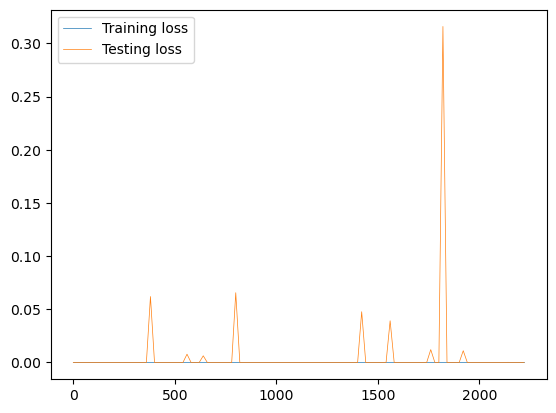

In [36]:
plt.plot(range(0, len(train_loss), 20), [l.item() for l in train_loss[::20]], 
         linewidth=0.5, label='Training loss')
plt.plot(range(0, len(test_loss), 20), [l.item() for l in test_loss[::20]], 
         linewidth=0.5, label='Testing loss')
plt.legend()

In [30]:
# Next possible steps: prediction 

# 1. Convert to Prediction Mode 
# model.eval()

# - Disables Dropout
# - Uses running stats in BatchNorm, not batch stats

# 2. Run Prediction (Disable Gradients)
# torch.no_grad() 

# model.eval()               # <-- switch to inference mode
# with torch.no_grad():      # <-- no gradient tracking
#     output = model(input)

###
# Prediction
# with torch.no_grad():
#     output = model(input_tensor)
#     predicted_class = torch.argmax(output, dim=1)

# print("Predicted class:", predicted_class.item())
### 